***

# **STA 221 Project Code**

***

## EDA

In [3]:
# packages

import time
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

# For Wordcloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

import string
import re
from collections import Counter

# Logistic Regression 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import plotly.express as px

In [4]:
tweets = pd.read_csv("Tweets.csv")

In [5]:
tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Graphs

In [6]:
# Company Logo color (or at least one of them) is mapped to each Airline respetively.
color_discrete_map = {
    "American": "#00a9e0",
    "United": "#005DAA",
    "Southwest": "#F9B612",
    "Delta": "#c8102e",
    "US Airways": "#bdc1c4",
    "Virgin America": "#5b056a"
}

# Plotting number of tweets per each sentiment per each airline
px.histogram(
    data_frame=tweets,
    x="airline_sentiment",
    color="airline",
    title="Sentiment Labels of Tweets by Airlines",
    labels={"airline_sentiment": "Sentiment of Tweet"},
    color_discrete_map=color_discrete_map,
)

In [7]:
# Retweets are very 0 inflated
px.histogram(data_frame=tweets,
    x="retweet_count")

In [8]:
# Looking at Reason per airline for all negative reviews
px.histogram(
    data_frame=tweets,
    x="negativereason",
    color="airline",
    title="Reason for Negative Tweets by Airline",
    labels={"negativereason": "Reason for Negative Tweet"},
    color_discrete_map=color_discrete_map,
)

### WordCloud

In [9]:
# Get one list
tweet_list = tweets["text"].tolist()

# Combine all tweets into a single string
all_tweets = " ".join(tweet_list)

# Load the plane image
plane_mask = np.array(Image.open("plane_image2.jpg"))

# color_list = np.array(['#b5d6e0',  '#ffef7a', '#f7c16a', '#ff6b3e', '#27214e'])

# Define a list of words to exclude
# Define stopwords
stopwords = set(STOPWORDS)
stopwords.update(
    [
        "the",
        "and",
        "to",
        "of",
        "a",
        "in",
        "for",
        "on",
        "is",
        "with",
        "that",
        "by",
        "this",
        "it",
        "as",
        "are",
        "be",
        "was",
        "from",
        "at",
        "will",
        "your",
        "but",
        "http",
        "you",
    ]
)

# Create a WordCloud object
# wordcloud_im = WordCloud(stopwords=stopwords, background_color='white', mask=plane_mask, color_func=color_list, width=1000, height=1000, max_words=125).generate(all_tweets)

# Plot the WordCloud image
# plt.figure(figsize=(10, 10), facecolor=None)
# plt.imshow(wordcloud_im)
# plt.axis("off")
# plt.tight_layout(pad=0)


# Save or display the image
# plt.savefig('tweet_wordcloud.png')
# plt.show()

# Lets do this by Sentiment, since this doesnt tell us much

In [10]:
def count_frequent_words(s, min_count=10):
    # Remove words that start with 'http'
    s = re.sub(r"\bhttp\S*", "", s)

    # Normalize the string: convert to lowercase and remove punctuation
    normalized_string = s.lower().translate(str.maketrans("", "", string.punctuation))

    # Split the string into words
    words = normalized_string.split()

    # Count words and filter those that appear at least 'min_count' times
    word_count = Counter(words)


    frequent_words = {
        word: count for word, count in word_count.items() if count >= min_count
    }

    # Get the number of unique words that show up greater than or equal too min count
    num_unique_words = len(set(frequent_words))

    return num_unique_words, frequent_words

def talk_clean_to_me(string_vec):
    # Remove words that start with 'http'
    string_vec = re.sub(r"\bhttp\S*", "", string_vec)

    # Normalize the string: convert to lowercase and remove punctuation
    normalized_string = string_vec.lower().translate(str.maketrans("", "", string.punctuation))

    return string_vec

#count_frequent_words(all_tweets_pos)[0]

#talk_clean_to_me(all_tweets_pos)

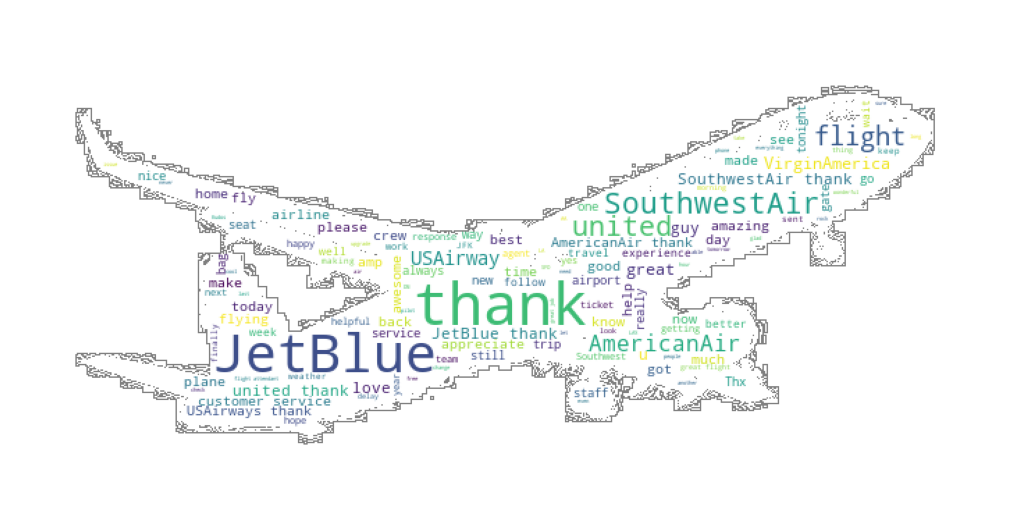

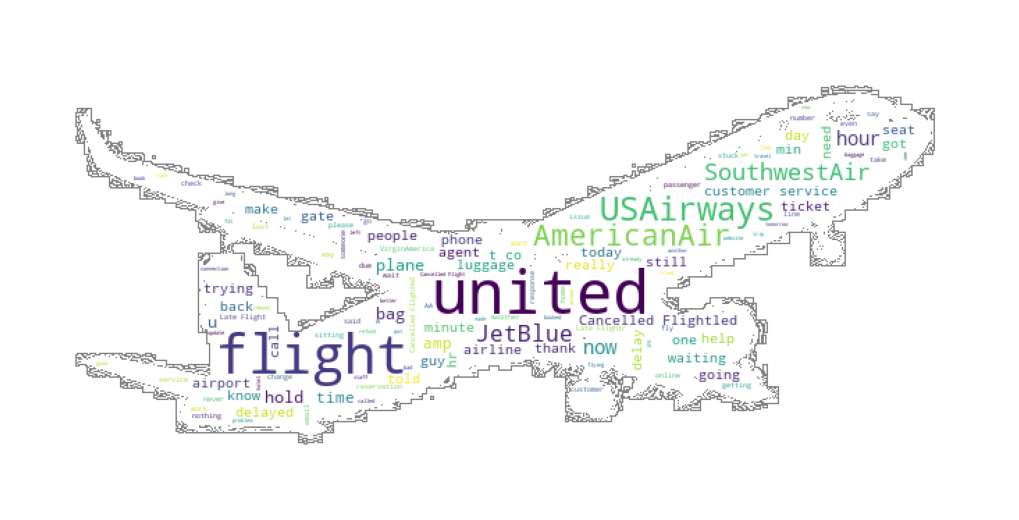

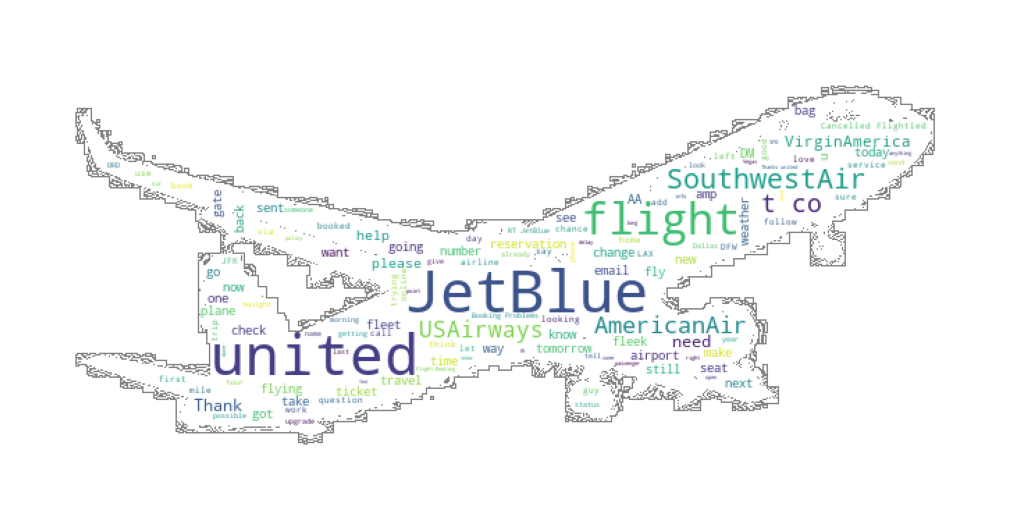

In [11]:
tweet_list_pos = tweets.loc[tweets["airline_sentiment"] == "positive", "text"]

all_tweets_pos = " ".join(tweet_list_pos)
all_tweets_pos = talk_clean_to_me(all_tweets_pos)

# Create a WordCloud object
wordcloud_im_pos = wordcloud.WordCloud(
    stopwords=stopwords,
    background_color="white",
    contour_color="grey",
    contour_width=0.01,
    mask=plane_mask,
    width=1000,
    height=1000,
    max_words=125,
).generate(all_tweets_pos)

# Plot the WordCloud image
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud_im_pos)
plt.axis("off")
plt.tight_layout(pad=0)


### Negative

tweet_list_neg = tweets.loc[tweets["airline_sentiment"] == "negative", "text"]

all_tweets_neg = " ".join(tweet_list_neg)

# Create a WordCloud object
wordcloud_im_neg = wordcloud.WordCloud(
    stopwords=stopwords,
    background_color="white",  # "#ccebfb",
    contour_color="grey",
    contour_width=0.01,
    mask=plane_mask,
    # width=1000,
    # height=1000,
    max_words=125,
).generate(all_tweets_neg)

# Plot the WordCloud image
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud_im_neg)
plt.axis("off")
plt.tight_layout(pad=0)

### Neutral
tweet_list_neu = tweets.loc[tweets["airline_sentiment"] == "neutral", "text"]

all_tweets_neu = " ".join(tweet_list_neu)

# Create a WordCloud object
wordcloud_im_neu = wordcloud.WordCloud(
    stopwords=stopwords,
    background_color="white",  # "#ccebfb",
    contour_color="grey",
    contour_width=0.01,
    mask=plane_mask,
    # width=1000,
    # height=1000,
    max_words=125,
).generate(all_tweets_neu)

# Plot the WordCloud image
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud_im_neu)
plt.axis("off")
plt.tight_layout(pad=0)

# Classification

### Binary Logistic Regression

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create feature vectors
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True)

# Only getting Binary labels
X = vectorizer.fit_transform(tweets.loc[(tweets["airline_sentiment"] == "positive") | (tweets["airline_sentiment"] == "negative"), 'text'])
y = tweets.loc[(tweets["airline_sentiment"] == "positive") | (tweets["airline_sentiment"] == "negative"), 'airline_sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))


Accuracy: 0.9142485924642703
              precision    recall  f1-score   support

    negative       0.92      0.98      0.95      1862
    positive       0.90      0.63      0.74       447

    accuracy                           0.91      2309
   macro avg       0.91      0.80      0.84      2309
weighted avg       0.91      0.91      0.91      2309



In [26]:
# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Get the coefficients from the logistic regression model
coefficients = model.coef_[0]

# Create a mapping of words to their coefficients
word_importance = dict(zip(feature_names, coefficients))

# Sort words by the absolute values of their coefficients
sorted_words = sorted(word_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Display the most influential words
#for word, coef in sorted_words[:10]:  # Adjust the number to display as needed
#    print(f"{word}: {coef}")

    # Sort words by the absolute values of their coefficients
sorted_words = sorted(word_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Convert the sorted words and coefficients into a DataFrame
df_word_importance = pd.DataFrame(sorted_words, columns=['Word', 'Coefficient'])

# Display the DataFrame
print(df_word_importance.head(50))  # Adjust the number to display as needed

             Word  Coefficient
0           thank     8.395879
1          thanks     8.306715
2           great     5.554231
3         awesome     4.546047
4             not    -4.501723
5            love     4.376813
6         amazing     4.062757
7              no    -4.028219
8            best     3.843459
9         worries     3.406265
10        jetblue     3.354490
11  virginamerica     3.262946
12        delayed    -3.210922
13           good     3.177672
14          hours    -3.161860
15          worst    -3.155040
16            thx     2.971658
17          kudos     2.961634
18     appreciate     2.804636
19           hold    -2.797258
20      cancelled    -2.680146
21   southwestair     2.667124
22      excellent     2.652081
23            why    -2.535804
24        nothing    -2.534693
25           hour    -2.240127
26      wonderful     2.146891
27           nice     2.143827
28           cool     2.111105
29        excited     2.052999
30           well     2.044423
31      

### Logistic Regression with L1 Penalty

In [34]:
# 'liblinear' is a good choice for small datasets, while 'saga' is faster for larger ones
model = LogisticRegression(penalty='l1', solver='saga', random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9060199220441749
              precision    recall  f1-score   support

    negative       0.92      0.97      0.94      1862
    positive       0.83      0.64      0.73       447

    accuracy                           0.91      2309
   macro avg       0.88      0.81      0.83      2309
weighted avg       0.90      0.91      0.90      2309



In [38]:
# Get the coefficients
coefficients = model.coef_[0]

# Map coefficients to features
feature_importance = dict(zip(feature_names, coefficients))

# Filter out features with zero coefficients
significant_features = {feature: coef for feature, coef in feature_importance.items() if coef != 0}

# Convert to DataFrame
df_significant_features = pd.DataFrame(list(significant_features.items()), columns=['Feature', 'Coefficient'])

# Order by the absolute value of the coefficients
df_significant_features = df_significant_features.reindex(df_significant_features['Coefficient'].abs().sort_values(ascending=False).index)

# Display the sorted DataFrame
print(df_significant_features.head(50))


           Feature  Coefficient
270          thank    13.948692
319        worries    12.716664
271         thanks    12.381620
122          great     9.261975
31         awesome     9.039908
161          kudos     8.408274
178           love     8.112687
200             no    -7.939530
16         amazing     7.856581
321          worst    -7.701340
143          hours    -7.407672
201            not    -7.381659
202        nothing    -6.682474
87       excellent     6.620304
42            best     6.546541
69         delayed    -6.361643
137           hold    -6.011341
89         excited     5.983762
315      wonderful     5.946816
279            thx     5.779574
51       cancelled    -5.750614
296  virginamerica     5.575201
119           good     5.572007
24      appreciate     5.335397
233           rock     5.270112
303        website    -5.114749
156        jetblue     4.877579
234           rude    -4.327450
60            cool     4.173159
253   southwestair     4.140582
150     

In [33]:
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

# Assuming y_train contains categorical labels like 'positive', 'negative'
# Assuming X_train and y_train are your features and target variable

# Initialize the LabelEncoder
#label_encoder = LabelEncoder()

# Fit and transform the labels to numeric
#y_train_encoded = label_encoder.fit_transform(y_train)

# Convert the sparse matrix to a dense array
#X_train_dense = X_train.toarray()

# Add a constant to the features
#X_train_sm = sm.add_constant(X_train_dense)

# Fit the model
#model_sm = sm.Logit(y_train_encoded, X_train_sm).fit()

# Display the summary
#print(model_sm.summary())

### SVM

In [ ]:
# SVM | https://medium.com/scrapehero/sentiment-analysis-using-svm-338d418e3ff1

train_vectors = vectorizer.fit_transform(tweets["text"])
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel="linear")
t0 = time.time()
classifier_linear.fit(train_vectors, tweets["airline_sentiment"])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1 - t0
time_linear_predict = t2 - t1
# results
print(
    "Training time: %fs; Prediction time: %fs"
    % (time_linear_train, time_linear_predict)
)
report = classification_report(testData["Label"], prediction_linear, output_dict=True)
print("positive: ", report["pos"])
print("negative: ", report["neg"])

NameError: name 'test_vectors' is not defined

In [ ]:
# https://www.educative.io/answers/how-to-use-svm-for-sentiment-analysis

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report


text = tweets["text"].values
labels = tweets["airline_sentiment"].values

text_train, text_test, labels_train, labels_test = train_test_split(
    text, labels, test_size=0.2, random_state=42
)

vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(text_train)
features_test = vectorizer.transform(text_test)

svm = SVC(kernel="linear")
svm.fit(features_train, labels_train)

predictions = svm.predict(features_test)
new_text = [
    "I hate Devin Booker",
    "Thai Canteen has awful service.",
    "The new Titebond glue is amazing.",
]
new_features = vectorizer.transform(new_text)
new_predictions = svm.predict(new_features)
print(new_predictions)

# Step 7: Generate the classification report to evaluate the model
print(classification_report(labels_test, predictions))

['negative' 'neutral' 'positive']
              precision    recall  f1-score   support

    negative       0.86      0.87      0.86      1889
     neutral       0.58      0.56      0.57       580
    positive       0.70      0.71      0.71       459

    accuracy                           0.78      2928
   macro avg       0.71      0.71      0.71      2928
weighted avg       0.78      0.78      0.78      2928



In [ ]:
# https://www.kaggle.com/code/lbronchal/sentiment-analysis-with-svm

data_clean = tweets[tweets["airline_sentiment_confidence"] > 0.65]
data_clean["sentiment"] = data_clean["airline_sentiment"].apply(
    lambda x: 1 if x == "negative" else 0
)

data_clean["text_clean"] = data_clean["text"].apply(
    lambda x: BeautifulSoup(x, "lxml").text
)